In [ ]:
# default_exp models

## models

In [ ]:
#export
from torchtools.core import *

In [ ]:
#export
import torch.nn as nn
import torch as torch
import torch.nn.functional as F

from functools import partial

from fastai2.layers import SigmoidRange
from fast_tabnet.core import *

import numpy as np

In [ ]:
torch.__version__

'1.3.1'

In [ ]:
torch.sigmoid(torch.tensor([-2.])) * (1 - -1) + -1

tensor([-0.7616])

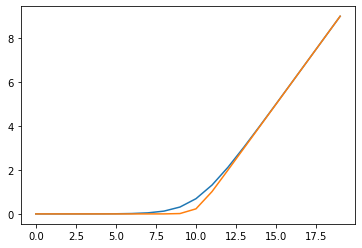

In [ ]:
import matplotlib.pyplot as plt
t = torch.arange(-10,10).float()
# plt.plot(t)
plt.plot(F.softplus(t, beta=1))
plt.plot(F.softplus(t, beta=3))

In [ ]:
#export
# This is an unofficial PyTorch implementation by Ignacio Oguiza - oguiza@gmail.com based on:

# Fawaz, H. I., Lucas, B., Forestier, G., Pelletier, C., Schmidt, D. F., Weber, J., ... & Petitjean, F. (2019). InceptionTime: Finding AlexNet for Time Series Classification. arXiv preprint arXiv:1909.04939.
# Official InceptionTime tensorflow implementation: https://github.com/hfawaz/InceptionTime


def noop(x):
    return x

def shortcut(c_in, c_out):
    return nn.Sequential(*[nn.Conv1d(c_in, c_out, kernel_size=1), 
                           nn.BatchNorm1d(c_out)])
    
class Inception(nn.Module):
    def __init__(self, c_in, bottleneck=32, ks=40, nb_filters=32):

        super().__init__()
        self.bottleneck = nn.Conv1d(c_in, bottleneck, 1) if bottleneck and c_in > 1 else noop
        mts_feat = bottleneck or c_in
        conv_layers = []
        kss = [ks // (2**i) for i in range(3)]
        # ensure odd kss until nn.Conv1d with padding='same' is available in pytorch 1.3
        kss = [ksi if ksi % 2 != 0 else ksi - 1 for ksi in kss]  
        for i in range(len(kss)):
            conv_layers.append(
                nn.Conv1d(mts_feat, nb_filters, kernel_size=kss[i], padding=kss[i] // 2))
        self.conv_layers = nn.ModuleList(conv_layers)
        self.maxpool = nn.MaxPool1d(3, stride=1, padding=1)
        self.conv = nn.Conv1d(c_in, nb_filters, kernel_size=1)
        self.bn = nn.BatchNorm1d(nb_filters * 4)
        self.act = nn.ReLU()

    def forward(self, x):
        input_tensor = x.to(torch.float)
        x = self.bottleneck(input_tensor)
        for i in range(3):
            out_ = self.conv_layers[i](x)
            if i == 0: out = out_
            else: out = torch.cat((out, out_), 1)
        mp = self.conv(self.maxpool(input_tensor))
        inc_out = torch.cat((out, mp), 1)
        return self.act(self.bn(inc_out))


class InceptionBlock(nn.Module):
    def __init__(self,c_in,bottleneck=32,ks=40,nb_filters=32,residual=True,depth=6):

        super().__init__()

        self.residual = residual
        self.depth = depth

        #inception & residual layers
        inc_mods = []
        res_layers = []
        res = 0
        for d in range(depth):
            inc_mods.append(
                Inception(c_in if d == 0 else nb_filters * 4, bottleneck=bottleneck if d > 0 else 0,ks=ks,
                          nb_filters=nb_filters))
            if self.residual and d % 3 == 2:
                res_layers.append(shortcut(c_in if res == 0 else nb_filters * 4, nb_filters * 4))
                res += 1
            else: res_layer = res_layers.append(None)
        self.inc_mods = nn.ModuleList(inc_mods)
        self.res_layers = nn.ModuleList(res_layers)
        self.act = nn.ReLU()
        
    def forward(self, x):
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inc_mods[d](x)
            if self.residual and d % 3 == 2:
                res = self.res_layers[d](res)
                x += res
                res = x
                x = self.act(x)
        return x

In [ ]:
#export    
class InceptionTime(nn.Module):
    def __init__(self,c_in,c_out,bottleneck=32,ks=40,nb_filters=32,residual=True,depth=6):
        super().__init__()
        self.block = InceptionBlock(c_in,bottleneck=bottleneck,ks=ks,nb_filters=nb_filters,
                                    residual=residual,depth=depth)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(nb_filters * 4, c_out)

    def forward(self, *x):
        x = torch.cat(x, dim=-2)
        x = self.block(x)
        x = self.gap(x).squeeze(-1)
        x = self.fc(x)
        return x

In [ ]:
#export
class Sigmoid(nn.Module):
    '''
    sigmoid layer
    '''
    def __init__(self, low, high):
        super().__init__()
        self.high, self.low = high, low
        
    def forward(self, x):
        return torch.sigmoid(x)*(self.high-self.low)+self.low

In [ ]:
#export
class InceptionTimeSgmOld(nn.Module):
    '''
    add a sigmoid layer to InceptionTime to get the ouput in a certain range
    '''
    
    def __init__(self, n_in, n_out):
        super().__init__()
        nn.Sequential()
        self.inc = InceptionTime(n_in, n_out)
        self.low, self.high = -1., 1.
        
    def forward(self, x):
        return torch.sigmoid(self.inc(x)) * (self.high - self.low) + self.low
        

In [ ]:
#export
class InceptionTimeSgm(nn.Module):
    '''
    add a sigmoid layer to InceptionTime to get the ouput in a certain range
    '''
    
    def __init__(self, n_in, n_out, range=(-1,1)):
        super().__init__()
        self.mod = nn.Sequential(InceptionTime(n_in, n_out), SigmoidRange(*range))
        
    def forward(self, x):
        x = x.float()
        return self.mod(x)
        

In [ ]:
#export
class InceptionTimeD(nn.Module):
    '''
    add a sigmoid layer to InceptionTime to get the ouput in a certain range
    '''
    
    def __init__(self, n_in, n_out):
        super().__init__()
        self.mod = nn.Sequential(InceptionTime(n_in, n_out), Sigmoid(-1., 1.))
        
    def forward(self, xc, xd):
        x = torch.cat([xc.float(), xd.float()], dim=-2)
        x = x.float()
#         print(f'InceptionTimeSgm dtype {x.dtype}')
        return self.mod(x)

### Mixed

In [ ]:
#export    
class InceptionTime_NH(nn.Module):
    '''inceptiontime, no final layer'''
    def __init__(self,c_in,c_out,bottleneck=32,ks=40,nb_filters=32,residual=True,depth=6):
        super().__init__()
        self.block = InceptionBlock(c_in,bottleneck=bottleneck,ks=ks,nb_filters=nb_filters,
                                    residual=residual,depth=depth)
        self.gap = nn.AdaptiveAvgPool1d(1)
#         self.fc = nn.Linear(nb_filters * 4, c_out)

    def forward(self, x):
        x = self.block(x)
#         print(x.shape)
        x = self.gap(x).squeeze(-1)
#         x = self.fc(x)
        return x

In [ ]:
def emb_sz_rule(n_cat):
    "Rule of thumb to pick embedding size corresponding to `n_cat`"
    return min(600, round(1.6 * n_cat**0.56))

# Cell
def _one_emb_sz(classes, n, sz_dict=None):
    "Pick an embedding size for `n` depending on `classes` if not given in `sz_dict`."
    sz_dict = ifnone(sz_dict, {})
    n_cat = len(classes[n])
    sz = sz_dict.get(n, int(emb_sz_rule(n_cat)))  # rule of thumb
    return n_cat,sz

# Cell
def get_emb_sz(to, sz_dict=None):
    "Get default embedding size from `TabularPreprocessor` `proc` or the ones in `sz_dict`"
    return [_one_emb_sz(to.classes,v n, sz_dict) for n in to.cat_names]

In [ ]:
#export
def _map_xs(xs, xs_mask):
    '''
    xs: i-tuple of tensors
    xs_mask: length j>=i mask
    xs_id: lenght j>=i string list of x identifiers 
    '''
    assert np.array(xs_mask).sum()==len(xs)
    res = np.array([None]*len(xs_mask))
    res[np.where(xs_mask)[0]]=xs
    return res

In [ ]:
#export
class InceptionTimeD_Mixed(nn.Module):
    '''
    mixed model for timeseries and tabular data
    ts_mod: InceptionTime model without final fully connected lay
    tab_mod: MLP or TabNet, currently both cont and cat is required
    outputs are concatenated, then put through a fully connected layer, then sigmoid range
    '''
    
    def __init__(self, n_c, n_d, n_out, n_cont, emb_szs=None):
        super().__init__()
        self.n_c, self.n_d, self.n_cont, self.emb_szs = n_c, n_d, n_out, emb_szs
        assert n_c>0, 'at least one continuous channel required'
        self.ts_mod = InceptionTime_NH(n_c+n_d, n_out) #128
        self.sgm = Sigmoid(-1,1)
#         self.mod = nn.Sequential(InceptionTime(n_in, n_out), Sigmoid(-1., 1.))
#         self.tab_mod = nn.Sequential(nn.Linear(2,100), nn.ReLU(), nn.Linear(100,64))
        self.tab_mod = TabNetModel(emb_szs=emb_szs, n_cont=n_cont, out_sz=64)
        self.fc = nn.Linear(192,n_out)
        
#     def forward(self, xc, xd, xt, xcat=None):
    def forward(self, *xs):
        
        
        xs_mask = [self.n_c>0, self.n_d>0, self.n_cont>0, len(self.emb_szs)>0]
#         x_type_idxs = [i for i in range(4) if has_x[i]]
        xc,xd,xt,xcat = map_xs(xs, xs_mask)
        
        x_ts=xc.float()
        if xd is not None: x_ts = torch.cat([x_ts, xd.float()], dim=-2)
        
#         x_ts=torch.cat([xs[0].float(), xd.float()], dim=-2) if self.n_d>0 else x_ts
        
        
#         x = t
#         x = x.float()
#         print(f'InceptionTimeSgm dtype {x.dtype}')
#         print(self.ts_mod(x).shape, self.tab_mod(xt.float().squeeze(-2)).shape )
        xcat=xcat.long() if xcat is not None else None
        xt=xt.float() if xt is not None else None
        x_all = torch.cat([self.ts_mod(x_ts), self.tab_mod(xcat, xt)], dim=-1)
        return self.sgm(self.fc(x_all))

In [ ]:
#export
class InceptionTime_Mixed(nn.Module):
    '''
    mixed model for timeseries and tabular data
    ts_mod: InceptionTime model without final fully connected lay
    tab_mod: MLP or TabNet, currently both cont and cat is required
    outputs are concatenated, then put through a fully connected layer, no sigmoid for classification
    '''
    
    def __init__(self, n_c, n_d, n_out, n_cont, emb_szs=None):
        super().__init__()
        self.n_c, self.n_d, self.n_cont, self.emb_szs = n_c, n_d, n_out, emb_szs
        assert n_c>0, 'at least one continuous channel required'
        self.ts_mod = InceptionTime_NH(n_c+n_d, n_out) #128
#         self.mod = nn.Sequential(InceptionTime(n_in, n_out), Sigmoid(-1., 1.))
#         self.tab_mod = nn.Sequential(nn.Linear(2,100), nn.ReLU(), nn.Linear(100,64))
        self.tab_mod = TabNetModel(emb_szs=emb_szs, n_cont=n_cont, out_sz=64)
        self.fc = nn.Linear(192,n_out)
        
#     def forward(self, xc, xd, xt, xcat=None):
    def forward(self, *xs):
        
        
        xs_mask = [self.n_c>0, self.n_d>0, self.n_cont>0, len(self.emb_szs)>0]
#         x_type_idxs = [i for i in range(4) if has_x[i]]
        xc,xd,xt,xcat = map_xs(xs, xs_mask)
        
        x_ts=xc.float()
        if xd is not None: x_ts = torch.cat([x_ts, xd.float()], dim=-2)
        
#         x_ts=torch.cat([xs[0].float(), xd.float()], dim=-2) if self.n_d>0 else x_ts
        
        
#         x = t
#         x = x.float()
#         print(f'InceptionTimeSgm dtype {x.dtype}')
#         print(self.ts_mod(x).shape, self.tab_mod(xt.float().squeeze(-2)).shape )
        xcat=xcat.long() if xcat is not None else None
        xt=xt.float() if xt is not None else None
        x_all = torch.cat([self.ts_mod(x_ts), self.tab_mod(xcat, xt)], dim=-1)
        return self.fc(x_all)

In [ ]:
TabNetModel()

In [ ]:
#export
class TabNetTT(nn.Module):
    '''
    convenience wrapper for pure TabNetModel models
    '''
    def __init__(self, emb_szs, n_cont, out_sz, **kwargs):
        super().__init__()
        self.tab = TabNetModel(emb_szs, n_cont, out_sz, **kwargs)
        
    def forward(self, xt, xcat):
        xcat=xcat.long() if xcat is not None else None
        xt=xt.float() if xt is not None else None
        return self.tab(xcat, xt)    

In [ ]:
xs = (torch.rand(5), torch.rand(5))
xs_mask = [True, False, False, True]
# xs_id = ['xa', 'xb', 'xc', 'xd']

In [ ]:
a,b,c,d = map_xs(xs, xs_mask)

In [ ]:
a, b, c, d

(tensor([0.7881, 0.9778, 0.3140, 0.2567, 0.1967]),
 None,
 None,
 tensor([0.6820, 0.7085, 0.3898, 0.3335, 0.7590]))

In [ ]:
l[np.where(np.array(xs_mask))[0]]

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
l = [None, None, None, None, None]
l=np.array(l)
l[np.where(np.array(xs_mask))[0]]=xs

In [ ]:
l

array([tensor([0.6260, 0.2170, 0.5897, 0.6390, 0.7939]), None, None,
       tensor([0.3255, 0.9235, 0.8020, 0.9128, 0.3032]), None],
      dtype=object)

In [ ]:
l[0,2]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
xa,xb,xc,xd = map_xs(xs, xs_mask, xs_id)
print((xa, xb, xc, xd))

(tensor([0.6263, 0.9378, 0.4598, 0.1943, 0.2437]), None, None, tensor([0.8345, 0.0159, 0.7012, 0.8561, 0.9810]))


In [ ]:
xs = (torch.rand(5), torch.rand(5))
xs_mask = [False, True, False, True]
xs_id = ['xa', 'xb', 'xc', 'xd']
xa,xb,xc,xd = map_xs(xs, xs_mask, xs_id)
print((xa, xb, xc, xd))

(None, tensor([0.1152, 0.8739, 0.6097, 0.4476, 0.8327]), None, tensor([0.7637, 0.0014, 0.7492, 0.7462, 0.4787]))


In [ ]:
np.where(np.array([True, False, True,True, False, False]))[0]

array([0, 2, 3])

In [ ]:
m = InceptionTimeD_Mixed(4,2,7,2,[])

In [ ]:
m

InceptionTimeD_Mixed(
  (ts_mod): InceptionTime_NH(
    (block): InceptionBlock(
      (inc_mods): ModuleList(
        (0): Inception(
          (conv_layers): ModuleList(
            (0): Conv1d(6, 32, kernel_size=(39,), stride=(1,), padding=(19,))
            (1): Conv1d(6, 32, kernel_size=(19,), stride=(1,), padding=(9,))
            (2): Conv1d(6, 32, kernel_size=(9,), stride=(1,), padding=(4,))
          )
          (maxpool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (conv): Conv1d(6, 32, kernel_size=(1,), stride=(1,))
          (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU()
        )
        (1): Inception(
          (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
          (conv_layers): ModuleList(
            (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,))
            (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,))
      

In [ ]:
TabNetModel??

In [ ]:
has_x = [True, False, True, True, False, True]
xs = (3,)

In [ ]:
import numpy as np
np.array(has_x[:3]).sum()

2

In [ ]:
def f(*xs):
        print(xs)

In [ ]:
torch.cat([torch.rand(5)])

tensor([0.4212, 0.7626, 0.0298, 0.4731, 0.0086])

In [ ]:
emb_szs=[]

In [ ]:
embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
n_emb = sum(e.embedding_dim for e in embeds)

In [ ]:
InceptionTimeD_Mixed(6,4,2,emb_szs=[(11,4)])

InceptionTimeD_Mixed(
  (ts_mod): InceptionTime_NH(
    (block): InceptionBlock(
      (inc_mods): ModuleList(
        (0): Inception(
          (conv_layers): ModuleList(
            (0): Conv1d(6, 32, kernel_size=(39,), stride=(1,), padding=(19,))
            (1): Conv1d(6, 32, kernel_size=(19,), stride=(1,), padding=(9,))
            (2): Conv1d(6, 32, kernel_size=(9,), stride=(1,), padding=(4,))
          )
          (maxpool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (conv): Conv1d(6, 32, kernel_size=(1,), stride=(1,))
          (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU()
        )
        (1): Inception(
          (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
          (conv_layers): ModuleList(
            (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,))
            (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,))
      

### Development

In [ ]:
#export
class InceptionTimeVar(nn.Module):
    '''
    output mean and variance
    regression model, sigmoid for the mean output optional
    '''
    
    def __init__(self, n_in, n_out, meanrange=None):
        super().__init__()
        models  = [InceptionTime(n_in, n_out+1)]
        if meanrange:
            self.sigmoid = Sigmoid(*meanrange)
        self.mod = nn.Sequential(*models)
        
    def forward(self, x):
        x = x.float()
        output = self.mod(x)
        ## enforce positivity of sigma^2
        ##output_sig_pos = tf.log(1 + tf.exp(output_sig)) + 1e-06
#         output[:,-1] = (output[:,-1].exp()+1).log_() + 1e-06
        output[:,-1] = F.softplus(output[:,-1].clone())
        
        if getattr(self, 'sigmoid', None): output[:,:-1] = self.sigmoid(output[:,:-1])
        return output
        

In [ ]:
# model sanity checks
xb = torch.randn((128,10,100))
yb = torch.rand(128,1)
model = InceptionTimeVar(10,1)

preds = model(xb)
assert preds.shape == (128,2)

In [ ]:
#export
def nll_regression(preds, y_true, c=5):
    '''
    negative log likelihood loss for regression, both mu and sigma are predicted
    
    Simple and Scalable Predictive UncertaintyEstimation using Deep Ensembles
    Balaji Lakshminarayanan, Alexander Pritzel, Charles Blundell, DeepMind

    '''
    
    s1 = 0.5*preds[:,1].log() 
    s2 = 0.5*(yb.squeeze()-preds[:,0]).pow(2).div(preds[:,1])
    loss = (s1+s2).mean() + c
    return loss

In [ ]:
#export
def nll_leaky_loss(preds, y_true, c=5, alpha=0.5):
    '''
    leaky_loss with variance
    
    Simple and Scalable Predictive UncertaintyEstimation using Deep Ensembles
    Balaji Lakshminarayanan, Alexander Pritzel, Charles Blundell, DeepMind

    '''
    
    s1 = 0.5*preds[:,1].log() 
    l1 = -F.leaky_relu(preds[:,0], alpha)*y_true.float().squeeze()
    s2 = 0.5*(l1.div(preds[:,1]+1)) ## +1 to prevent optimizing for variance, maybe just an artifical problem
    loss = (s1+s2).mean() + c
    return loss

In [ ]:
loss = nll_leaky_loss(preds, yb)

print(loss)

tensor(5.0285, grad_fn=<AddBackward0>)


In [ ]:
model_var = InceptionTimeVar(10,1,meanrange=(-1,1))

In [ ]:
#cuda
#simple training loop

lr = 0.01
epochs = 10
loss_fn = nll_regression
m = model_var
loss_fn = nll_leaky_loss


for i in range(epochs):
    preds = m(xb)
    loss = loss_fn(preds, yb)
    print(loss)
    loss.backward()
    with torch.no_grad():
        for p in m.parameters():
            p.sub_(lr*p.grad)
    m.zero_grad()

tensor(4.9921, grad_fn=<AddBackward0>)
tensor(4.9292, grad_fn=<AddBackward0>)
tensor(4.8599, grad_fn=<AddBackward0>)
tensor(4.7835, grad_fn=<AddBackward0>)
tensor(4.6996, grad_fn=<AddBackward0>)
tensor(4.6080, grad_fn=<AddBackward0>)
tensor(4.5083, grad_fn=<AddBackward0>)
tensor(4.4009, grad_fn=<AddBackward0>)
tensor(4.2859, grad_fn=<AddBackward0>)
tensor(4.1640, grad_fn=<AddBackward0>)


In [ ]:
unweighted_profit(m(xb)[:,0], yb)

tensor(0.)

In [ ]:
model_var = InceptionTimeVar(10,1)
opt = torch.optim.Adam(model_var.parameters(), lr=0.001)

In [ ]:
#cuda
m = model_var
for i in range(epochs):
    preds = m(xb)
    loss = nll_regression(preds, yb)
    print(loss)
    loss.backward()
    with torch.no_grad():
        opt.step()
        opt.zero_grad()
        

tensor(5.3211, grad_fn=<AddBackward0>)
tensor(5.0782, grad_fn=<AddBackward0>)
tensor(4.9166, grad_fn=<AddBackward0>)
tensor(4.8056, grad_fn=<AddBackward0>)
tensor(4.7254, grad_fn=<AddBackward0>)
tensor(4.6706, grad_fn=<AddBackward0>)
tensor(4.6308, grad_fn=<AddBackward0>)
tensor(4.5937, grad_fn=<AddBackward0>)
tensor(4.5542, grad_fn=<AddBackward0>)
tensor(4.4943, grad_fn=<AddBackward0>)


In [ ]:
#cuda
model_var = InceptionTimeVar(10,1,meanrange=(-10,5))
m = model_var
loss_fn = partial(nll_leaky_loss, alpha=0.5)
epochs=10

opt = torch.optim.Adam(m.parameters(), lr=1e-4)

for i in range(epochs):
    preds = m(xb)
    loss = loss_fn(preds, yb)
    print(loss)
    print(unweighted_profit(preds[:,0], yb))
    loss.backward()
    with torch.no_grad():
        opt.step()
        opt.zero_grad()
        

tensor(4.7368, grad_fn=<AddBackward0>)
tensor(0.)
tensor(4.7209, grad_fn=<AddBackward0>)
tensor(0.)
tensor(4.7053, grad_fn=<AddBackward0>)
tensor(0.)
tensor(4.6899, grad_fn=<AddBackward0>)
tensor(0.)
tensor(4.6746, grad_fn=<AddBackward0>)
tensor(0.)
tensor(4.6594, grad_fn=<AddBackward0>)
tensor(0.)
tensor(4.6443, grad_fn=<AddBackward0>)
tensor(0.)
tensor(4.6291, grad_fn=<AddBackward0>)
tensor(0.)
tensor(4.6138, grad_fn=<AddBackward0>)
tensor(0.)
tensor(4.5980, grad_fn=<AddBackward0>)
tensor(0.0075)


In [ ]:
unweighted_profit(m(xb)[:,0],yb)

tensor(0.0187)

In [ ]:
import numpy as np

In [ ]:
np.round(m(xb).detach().numpy(), 2)

array([[-0.24,  0.41],
       [-0.77,  0.37],
       [-1.81,  0.34],
       [-3.6 ,  0.34],
       [ 0.49,  0.42],
       [-0.82,  0.41],
       [-0.84,  0.4 ],
       [-1.05,  0.35],
       [-1.3 ,  0.34],
       [-3.04,  0.29],
       [-1.94,  0.36],
       [-1.5 ,  0.37],
       [-0.93,  0.4 ],
       [-1.24,  0.39],
       [-2.31,  0.34],
       [-2.13,  0.35],
       [-2.28,  0.34],
       [-1.16,  0.4 ],
       [-2.3 ,  0.37],
       [-0.31,  0.4 ],
       [-0.99,  0.39],
       [-2.82,  0.32],
       [-1.4 ,  0.36],
       [-1.21,  0.38],
       [-1.85,  0.35],
       [-2.52,  0.31],
       [-0.78,  0.39],
       [-0.78,  0.35],
       [-1.72,  0.36],
       [-0.28,  0.42],
       [-1.53,  0.39],
       [-1.91,  0.38],
       [-0.84,  0.38],
       [ 0.08,  0.4 ],
       [-1.78,  0.36],
       [-2.64,  0.34],
       [-1.59,  0.38],
       [-0.46,  0.37],
       [-2.69,  0.41],
       [-1.29,  0.36],
       [-1.29,  0.37],
       [-0.14,  0.43],
       [-0.64,  0.42],
       [-1.

In [ ]:
x1 = torch.zeros(128,1)
x2 = torch.ones(128,1)

In [ ]:
x_p = torch.cat([x1,x2], dim=1)

In [ ]:
nll_regression(x_p, yb)

tensor(5.1578)

In [ ]:
t=torch.randn(100)
torch.sigmoid(t)*(1.3-0.9)+0.9


tensor([1.2412, 1.1038, 1.0968, 1.1289, 1.1712, 1.2208, 1.1951, 1.1454, 1.1252,
        1.1933, 1.0675, 1.1149, 1.1066, 1.0956, 1.1696, 1.0552, 1.0579, 0.9636,
        1.0129, 1.0893, 0.9862, 1.0107, 1.0038, 1.0636, 1.1439, 0.9745, 1.1000,
        1.2131, 1.1016, 1.2258, 1.1087, 1.2406, 1.0853, 1.1349, 1.0362, 1.1309,
        1.0748, 1.2192, 0.9677, 1.0714, 1.2125, 0.9704, 1.0656, 1.1497, 1.1989,
        1.0258, 1.0785, 1.2363, 1.1467, 1.2652, 1.1868, 1.0978, 1.2464, 1.0098,
        1.2476, 1.1435, 1.1949, 1.2127, 1.1184, 1.0172, 1.1773, 1.0714, 1.2171,
        1.2256, 1.0014, 1.1111, 1.0696, 0.9619, 1.0394, 1.0350, 1.1551, 1.2075,
        1.1798, 1.0780, 1.0359, 1.1595, 1.1368, 1.2355, 1.0904, 1.1077, 1.2141,
        1.1579, 1.2191, 0.9764, 1.1609, 1.1440, 1.1462, 1.0915, 1.2595, 1.1571,
        1.0948, 1.0177, 1.0333, 1.1375, 1.0431, 1.1731, 1.1842, 1.1336, 1.0594,
        0.9231])

In [ ]:
torch.sigmoid(t)

tensor([0.8529, 0.5096, 0.4920, 0.5722, 0.6781, 0.8021, 0.7378, 0.6134, 0.5630,
        0.7333, 0.4188, 0.5373, 0.5166, 0.4889, 0.6739, 0.3879, 0.3948, 0.1589,
        0.2823, 0.4732, 0.2154, 0.2768, 0.2596, 0.4089, 0.6098, 0.1863, 0.4999,
        0.7829, 0.5040, 0.8145, 0.5218, 0.8515, 0.4632, 0.5873, 0.3405, 0.5772,
        0.4370, 0.7979, 0.1692, 0.4284, 0.7813, 0.1761, 0.4139, 0.6243, 0.7473,
        0.3146, 0.4463, 0.8406, 0.6166, 0.9130, 0.7170, 0.4946, 0.8661, 0.2745,
        0.8691, 0.6086, 0.7372, 0.7816, 0.5459, 0.2930, 0.6932, 0.4285, 0.7927,
        0.8141, 0.2535, 0.5278, 0.4240, 0.1548, 0.3485, 0.3376, 0.6376, 0.7688,
        0.6995, 0.4450, 0.3398, 0.6487, 0.5921, 0.8388, 0.4760, 0.5193, 0.7853,
        0.6446, 0.7977, 0.1909, 0.6523, 0.6101, 0.6155, 0.4787, 0.8987, 0.6428,
        0.4870, 0.2943, 0.3332, 0.5939, 0.3577, 0.6827, 0.7106, 0.5839, 0.3985,
        0.0578])

In [ ]:
def _create_random_results(size):
    high, low = 1.2, 0.9
    res=torch.randn(size)
    res = torch.sigmoid(res)*(high-low)+low
    res *= -100
    res[torch.rand(size)>0.5] = 100.
    return res

In [ ]:
yb = _create_random_results((128,1))

In [ ]:
nll_leaky_loss(preds, yb)

tensor(3.0676, grad_fn=<AddBackward0>)

In [ ]:
yb.mean()

tensor(-3.7970)

In [ ]:
model_var = InceptionTimeVar(10,1,meanrange=(-1,1))
m = model_var
loss_fn = partial(nll_leaky_loss, alpha=0.5)
epochs=20

opt = torch.optim.Adam(m.parameters(), lr=1e-4)

In [ ]:
#cuda
for i in range(epochs):
    preds = m(xb)
    loss = loss_fn(preds, yb)
    print(loss)
    print(unweighted_profit(preds[:,0], yb))
    loss.backward()
    with torch.no_grad():
        opt.step()
        opt.zero_grad()
        

tensor(5.5096, grad_fn=<AddBackward0>)
tensor(-3.7970)
tensor(5.1599, grad_fn=<AddBackward0>)
tensor(-3.7970)
tensor(4.8130, grad_fn=<AddBackward0>)
tensor(-3.7970)
tensor(4.4551, grad_fn=<AddBackward0>)
tensor(-3.7970)
tensor(4.0745, grad_fn=<AddBackward0>)
tensor(-3.7970)
tensor(3.6592, grad_fn=<AddBackward0>)
tensor(-3.7970)
tensor(3.1964, grad_fn=<AddBackward0>)
tensor(-3.7970)
tensor(2.6728, grad_fn=<AddBackward0>)
tensor(-3.7970)
tensor(2.0750, grad_fn=<AddBackward0>)
tensor(-3.7970)
tensor(1.3914, grad_fn=<AddBackward0>)
tensor(-3.7970)
tensor(0.6170, grad_fn=<AddBackward0>)
tensor(-3.6784)
tensor(-0.2108, grad_fn=<AddBackward0>)
tensor(-3.4114)
tensor(-1.0847, grad_fn=<AddBackward0>)
tensor(-3.2334)
tensor(-1.9718, grad_fn=<AddBackward0>)
tensor(-2.7291)
tensor(-2.8243, grad_fn=<AddBackward0>)
tensor(-2.3731)
tensor(-3.6813, grad_fn=<AddBackward0>)
tensor(-2.3138)
tensor(-4.5413, grad_fn=<AddBackward0>)
tensor(-2.1655)
tensor(-5.3586, grad_fn=<AddBackward0>)
tensor(-2.0172)
ten

In [ ]:
#cuda
for i in range(epochs):
    preds = m(xb)
    loss = loss_fn(preds, yb)
    print(loss)
    print(unweighted_profit(preds[:,0], yb))
    loss.backward()
    with torch.no_grad():
        opt.step()
        opt.zero_grad()
        

tensor(-7.4223, grad_fn=<AddBackward0>)
tensor(-1.8985)
tensor(-7.9829, grad_fn=<AddBackward0>)
tensor(-1.8688)
tensor(-8.4926, grad_fn=<AddBackward0>)
tensor(-1.8688)
tensor(-8.9576, grad_fn=<AddBackward0>)
tensor(-1.8688)
tensor(-9.3802, grad_fn=<AddBackward0>)
tensor(-1.8688)
tensor(-9.7627, grad_fn=<AddBackward0>)
tensor(-1.8688)
tensor(-10.1091, grad_fn=<AddBackward0>)
tensor(-1.8688)
tensor(-10.4264, grad_fn=<AddBackward0>)
tensor(-1.8688)
tensor(-10.7213, grad_fn=<AddBackward0>)
tensor(-1.8688)
tensor(-11.0006, grad_fn=<AddBackward0>)
tensor(-1.8688)
tensor(-11.2681, grad_fn=<AddBackward0>)
tensor(-1.8688)
tensor(-11.5253, grad_fn=<AddBackward0>)
tensor(-1.8688)
tensor(-11.7730, grad_fn=<AddBackward0>)
tensor(-1.8688)
tensor(-12.0138, grad_fn=<AddBackward0>)
tensor(-1.8688)
tensor(-12.2503, grad_fn=<AddBackward0>)
tensor(-1.8688)
tensor(-12.4847, grad_fn=<AddBackward0>)
tensor(-1.8688)
tensor(-12.7178, grad_fn=<AddBackward0>)
tensor(-1.8688)
tensor(-12.9498, grad_fn=<AddBackward

In [ ]:
m(xb)

tensor([[-0.6247,  1.3449],
        [-0.6335,  1.3496],
        [ 0.9159,  0.4525],
        [ 0.8944,  0.5261],
        [ 0.9143,  0.4376],
        [ 0.9153,  0.4637],
        [-0.6126,  1.3296],
        [ 0.9140,  0.4445],
        [-0.5532,  1.3306],
        [-0.6109,  1.3950],
        [-0.6027,  1.3360],
        [-0.6743,  1.3920],
        [ 0.9251,  0.4406],
        [ 0.8916,  0.4790],
        [ 0.9104,  0.4841],
        [-0.6220,  1.4334],
        [-0.6139,  1.3183],
        [ 0.8935,  0.4824],
        [-0.6616,  1.3746],
        [ 0.8775,  0.5117],
        [-0.6336,  1.3861],
        [ 0.8849,  0.4871],
        [-0.4994,  1.2708],
        [ 0.8904,  0.5076],
        [-0.5878,  1.3920],
        [ 0.8754,  0.5185],
        [-0.6419,  1.3675],
        [ 0.8800,  0.5075],
        [-0.5670,  1.2860],
        [ 0.9170,  0.4520],
        [ 0.9310,  0.4050],
        [ 0.9005,  0.4669],
        [-0.6053,  1.3027],
        [-0.6309,  1.3387],
        [ 0.9197,  0.4594],
        [ 0.9192,  0

In [ ]:
#cuda
model_mean = InceptionTimeSgm(10,1, range=(-1,1))
m = model_mean
loss_fn = partial(leaky_loss, alpha=0.1)
# loss_fn = F.mse_loss

epochs=2

opt = torch.optim.Adam(m.parameters(), lr=1e-3)

for i in range(epochs):
    preds = m(xb)
    loss = loss_fn(preds, yb)
    print(loss)
    print(unweighted_profit(preds, yb))
    loss.backward()
    with torch.no_grad():
        opt.step()
        opt.zero_grad()
        

tensor(-0.0298, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.0697, grad_fn=<MulBackward0>)
tensor(0.)


In [ ]:
np.round(preds.detach().numpy(),2)

array([[-0.22],
       [-0.17],
       [-0.16],
       [-0.18],
       [-0.23],
       [-0.18],
       [-0.19],
       [-0.17],
       [-0.18],
       [-0.18],
       [-0.15],
       [-0.16],
       [-0.23],
       [-0.21],
       [-0.16],
       [-0.18],
       [-0.21],
       [-0.2 ],
       [-0.2 ],
       [-0.16],
       [-0.18],
       [-0.2 ],
       [-0.16],
       [-0.14],
       [-0.19],
       [-0.2 ],
       [-0.18],
       [-0.2 ],
       [-0.21],
       [-0.16],
       [-0.19],
       [-0.19],
       [-0.18],
       [-0.15],
       [-0.18],
       [-0.2 ],
       [-0.18],
       [-0.17],
       [-0.19],
       [-0.15],
       [-0.17],
       [-0.17],
       [-0.17],
       [-0.15],
       [-0.2 ],
       [-0.18],
       [-0.22],
       [-0.22],
       [-0.21],
       [-0.16],
       [-0.22],
       [-0.14],
       [-0.19],
       [-0.16],
       [-0.17],
       [-0.18],
       [-0.17],
       [-0.17],
       [-0.22],
       [-0.17],
       [-0.18],
       [-0.18],
       [

In [ ]:
weighted_profit(preds, yb, threshold=70)

tensor(0., grad_fn=<MeanBackward0>)

In [ ]:
l1 = F.leaky_relu(preds[:,0], 0.5)*yb.float().squeeze()

In [ ]:
l1.mean()

tensor(0.3143, grad_fn=<MeanBackward0>)

In [ ]:
unweighted_profit(preds[:,0], yb)

tensor(0.)

In [ ]:
F.leaky_relu(preds[:,0], 0.01)

tensor([-0.0022, -0.0017, -0.0016, -0.0018, -0.0023, -0.0018, -0.0019, -0.0017,
        -0.0018, -0.0018, -0.0015, -0.0016, -0.0023, -0.0021, -0.0016, -0.0018,
        -0.0021, -0.0020, -0.0020, -0.0016, -0.0018, -0.0020, -0.0016, -0.0014,
        -0.0019, -0.0020, -0.0018, -0.0020, -0.0021, -0.0016, -0.0019, -0.0019,
        -0.0018, -0.0015, -0.0018, -0.0020, -0.0018, -0.0017, -0.0019, -0.0015,
        -0.0017, -0.0017, -0.0017, -0.0015, -0.0020, -0.0018, -0.0022, -0.0022,
        -0.0021, -0.0016, -0.0022, -0.0014, -0.0019, -0.0016, -0.0017, -0.0018,
        -0.0017, -0.0017, -0.0022, -0.0017, -0.0018, -0.0018, -0.0013, -0.0017,
        -0.0017, -0.0020, -0.0017, -0.0020, -0.0013, -0.0018, -0.0019, -0.0018,
        -0.0021, -0.0021, -0.0015, -0.0019, -0.0021, -0.0014, -0.0020, -0.0021,
        -0.0021, -0.0021, -0.0017, -0.0019, -0.0017, -0.0023, -0.0018, -0.0020,
        -0.0016, -0.0019, -0.0021, -0.0019, -0.0018, -0.0018, -0.0022, -0.0017,
        -0.0020, -0.0018, -0.0021, -0.00

In [ ]:
l1

tensor([ 11.9359,   8.0182,  -7.7866,  -9.0861, -11.4707,  -8.9106,  10.3597,
         -8.5555,   9.3440,   8.4255,   7.4203,   8.2735, -11.3047, -10.5139,
         -7.8700,   9.4019,  10.7593, -10.0267,  11.5149,  -7.8406,  10.6564,
        -10.2022,   7.4194,  -7.1230,   9.0873,  -9.9591,   8.8141, -10.2012,
         10.9219,  -8.2058,  -9.4535,  -9.6962,   9.5209,   8.0113,  -9.0895,
        -10.1661,  -8.7832,   9.3378,  10.4465,   8.1611,   9.0926,   7.9269,
         -8.4618,   7.2584,  -9.9300,  -9.0956, -10.9277, -11.0166,  11.3946,
         -8.0560,  11.3752,  -6.8826,   9.9466,  -8.2181,   9.5487,  -9.1482,
         -8.7303,   8.3823,  11.5327,  -8.7412,  -9.1766,   9.8428,   6.7408,
          7.8306,   9.1732, -10.1838,  -8.7309,  -9.9286,  -6.6186,   9.1171,
         -9.2919,  -8.9576,  10.8023, -10.2791,   8.7763,  -9.3696,  10.8481,
          7.8006, -10.1285,  12.4134,  10.9164, -10.6060,  -8.6401,  -9.4403,
         -8.5532,  12.2043,  -9.0122, -10.1679,  -8.2355,  10.31

### QD loss

High-Quality Prediction Intervals for Deep Learning: A Distribution-Free, Ensembled Approach

In [ ]:
y_results = _create_random_results(10)

In [ ]:
y_results

tensor([ -94.4114, -115.2035,  100.0000,  100.0000, -105.0282, -111.8546,
         100.0000,  100.0000, -102.5273, -107.5752])

In [ ]:
preds = torch.randn(10)

In [ ]:
y_lower=preds

In [ ]:
y_upper = preds + torch.rand(10)

In [ ]:
#hard
y_toy = torch.randn(10)

In [ ]:
khu = (torch.sign(y_upper-y_toy) > 0).int()

In [ ]:
khl = (torch.sign(y_toy-y_lower) > 0).int()

In [ ]:
##soft
s = 10
ksu = torch.sigmoid((y_upper-y_toy)*s)
ksl = torch.sigmoid((y_toy-y_lower)*s)


In [ ]:
np.round(ksu.numpy(),4)

array([0.    , 1.    , 1.    , 1.    , 1.    , 0.0043, 0.9947, 0.0039,
       1.    , 0.0485], dtype=float32)

In [ ]:
np.round(ksl.numpy(), 3)

array([1.   , 0.061, 0.   , 0.   , 0.001, 0.999, 0.028, 1.   , 0.   ,
       1.   ], dtype=float32)

In [ ]:
##soft
s = 10
ksu = torch.sigmoid((y_upper-y_results)*s)
ksl = torch.sigmoid((y_results-y_lower)*s)

In [ ]:
ksu

tensor([1., 1., 0., 0., 1., 1., 0., 0., 1., 1.])

In [ ]:
ksl

tensor([0., 0., 1., 1., 0., 0., 1., 1., 0., 0.])

In [ ]:
y_results

tensor([ -94.4114, -115.2035,  100.0000,  100.0000, -105.0282, -111.8546,
         100.0000,  100.0000, -102.5273, -107.5752])

In [ ]:
y_upper

tensor([-1.3337,  0.9843,  1.1095, -0.3597,  1.0252, -1.1859, -0.4918,  0.0426,
         0.7183, -0.3774])

In [ ]:
torch.sigmoid(y_upper*y_results*0.01)

tensor([0.7789, 0.2434, 0.7520, 0.4110, 0.2541, 0.7903, 0.3795, 0.5107, 0.3238,
        0.6001])

Betting adaption

Given results targets `y_results`

In [ ]:
y_results

tensor([ -94.4114, -115.2035,  100.0000,  100.0000, -105.0282, -111.8546,
         100.0000,  100.0000, -102.5273, -107.5752])

the NN predicts upper and lower bounds `y_upper`, `y_lower`

In [ ]:
y_upper, y_lower

(tensor([-1.3337,  0.9843,  1.1095, -0.3597,  1.0252, -1.1859, -0.4918,  0.0426,
          0.7183, -0.3774]),
 tensor([-1.4573,  0.1762,  1.0387, -0.9068,  0.2352, -1.3277, -0.6610, -0.3312,
         -0.1677, -0.9362]))

Similarly to leaky loss, we want both bounds to have the same sign as the target `y_results` and higher absolute values for more confidence

In [ ]:
#export
def qd_loss(preds, y_true, alpha=0.4, l=0.01, s=0.01, add=False, slope=1.):
    '''
    qd loss implementation adapted for "leaky loss problems"
    preds: predictions for both lower and upper bounds
    alpha: confidence intervall parameter, different from alpha in leaky_loss
    s: smoothing factor for sigmoid
    l: agrangian controlling width vs coverage (default in the paper impl. is 0.01 which seems lowI)
    '''
    ll = lambda x: F.leaky_relu(x, negative_slope=slope)
    
    y_lower = preds[:,0].clone()
    y_upper = preds[:,1].clone() if not add else y_lower+preds[:,1]
    
#     if not add:
#         y_lower, y_upper = preds[:, 0].clone(), preds[:, 1].clone()
#     else:
#         y_lower, y_upper = preds[:, 0].clone(), preds[:,0].clone()+preds[:, 1].clone()
# #     hard counts, how many of the predictions have the right sign?
    khu = (torch.sign(y_upper*y_true) > 0).int()
    khl = (torch.sign(y_lower*y_true) > 0).int()
    
#     return preds.mean()
    # soft counts, sign step function replaced by a smoother sigmoid
    
    ksu = torch.sigmoid((ll(y_upper)*y_true)*s)
    ksl = torch.sigmoid((y_true*ll(y_lower))*s)
    kh,ks = khu*khl, ksu*ksl
#     print(kh)
#     print(kh.sum(), ks.sum())
    
    #mpiw: mean predicted interval width
    f = 1/(kh.sum()+1e-6)
#     print((y_upper-y_lower))
    mpiw = ((y_upper-y_lower)*kh).sum()*f
    
    #picp: predicted interval coverage probability
    picp_s = ks.mean()
    
    print(f'mpiw {mpiw}, pcip_soft: {picp_s}')
    s2 = l*preds.shape[0]/(alpha*(1-alpha))
    s3 = torch.max(torch.zeros(1, device=preds.device), picp_s).pow(2)
    loss_s = mpiw + l*preds.shape[0]/(alpha*(1-alpha)) * torch.max(torch.zeros(1, device=preds.device), 
                                                                   picp_s).pow(2)
    return loss_s

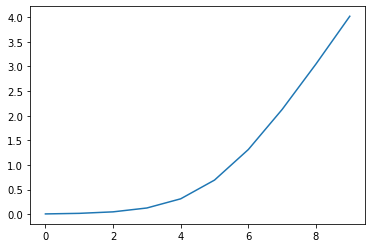

In [ ]:
plt.plot(F.softplus(torch.arange(-5,5).float()))

/home/johannes/anaconda3/envs/nbdev/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


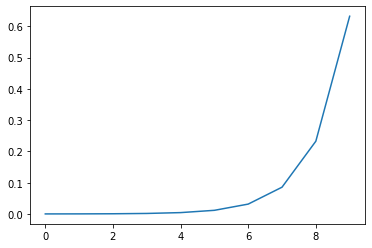

In [ ]:
plt.plot(F.softmax(torch.arange(-5,5).float()))

In [ ]:
#export
class InceptionTimeBounds(nn.Module):
    '''
    use InceptionTimeVar implementation for bounds
    output[:, -1] is positive and y_upper corresponds to output[:,0]+output[:,1] --> loss
    '''
    
    def __init__(self, n_in, n_out, meanrange=None):
        super().__init__()
        models  = [InceptionTime(n_in, n_out+1)]
        if meanrange:
            self.sigmoid = Sigmoid(*meanrange)
        self.mod = nn.Sequential(*models)
        
    def forward(self, x):
        x = x.float()
        output = self.mod(x)
        ## enforce positivity of sigma^2
        ##output_sig_pos = tf.log(1 + tf.exp(output_sig)) + 1e-06
#         output[:,-1] = (output[:,-1].exp()+1).log_() + 1e-06
        output[:,-1] = F.softplus(output[:,-1].clone())  ## autograd problems when not using clone, why???
        
        if getattr(self, 'sigmoid', None): output[:,:-1] = self.sigmoid(output[:,:-1])
        return output

In [ ]:
model = InceptionTimeBounds(10,1, meanrange=(-3,3))

In [ ]:
y_true = _create_random_results(128)

In [ ]:
y_true

tensor([-106.7638,  100.0000, -100.0458,  100.0000,  100.0000, -109.3803,
        -107.8266,  100.0000,  100.0000, -113.7330, -110.4757,  100.0000,
         100.0000,  100.0000,  -99.7512,  100.0000, -108.8533,  -98.5843,
        -101.6713, -102.8774, -110.6917,  100.0000,  -96.2356,  100.0000,
         100.0000, -104.1054,  100.0000,  100.0000,  100.0000,  100.0000,
         -99.7910, -110.3254, -109.7371,  100.0000,  100.0000, -101.7797,
         -94.8627,  100.0000,  100.0000,  100.0000, -110.1486,  100.0000,
        -116.1869, -102.9370,  -95.7134, -116.2622, -107.7277,  -92.6611,
         100.0000,  100.0000,  100.0000, -110.8954, -100.5063,  100.0000,
        -106.7785,  100.0000,  100.0000, -117.0415,  -98.9544, -101.8524,
         100.0000,  100.0000,  100.0000,  100.0000, -104.1076, -115.2596,
         100.0000,  -98.1928, -104.9685, -113.3826,  100.0000,  100.0000,
        -111.9894, -105.9567,  100.0000,  -95.4433,  100.0000, -112.9684,
        -106.2161, -104.0756,  100.000

In [ ]:
qd_loss(model(xb), y_true, add=True, slope=0.2)

mpiw 0.5742294788360596, pcip_soft: 0.2512679100036621


tensor([0.9110], grad_fn=<AddBackward0>)